# Titanic - XGBoost - TJS

## Packages

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

pd.set_option("display.max_rows", 50)

## Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
raw = pd.read_csv('/kaggle/input/titanic/train.csv')

## Helper Functions

In [4]:
def custom_hist(df):
    num_features = df.select_dtypes(include='number').shape[1]
    rows = -(-num_features // 2)

    return df.hist(figsize=(12, 4 * rows), layout=(rows, 2))

In [5]:
def train_xgb_model(X_train,y_train,X_val,y_val,params=None,verbose=True):
    
    if params is None:
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "random_state": 42,
            "tree_method": "hist",
            "learning_rate": 0.1,
            "n_estimators": 1000,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "reg_lambda": 1.0,
            "missing": np.nan,
            "early_stopping_rounds": 50
        }

    model = XGBClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=verbose
    )

    return model

## Split Data

In [6]:
TARGET = 'Survived'
ID = 'PassengerId'

In [7]:
df_train, df_val = train_test_split(raw, test_size=0.2, random_state=42, stratify=raw[TARGET])

## EDA (Exploratory Data Analysis)

In [8]:
df_train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          575 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        160 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [10]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,0.383427,2.308989,29.807687,0.492978,0.390449,31.819826
std,257.465527,0.486563,0.833563,14.485211,1.060720,0.838134,48.059104
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,0.000000,3.000000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,1.000000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
df_train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,712,712,712,160,710
unique,712,2,571,127,3
top,"Lam, Mr. Ali",male,1601,G6,S
freq,1,459,6,4,516


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

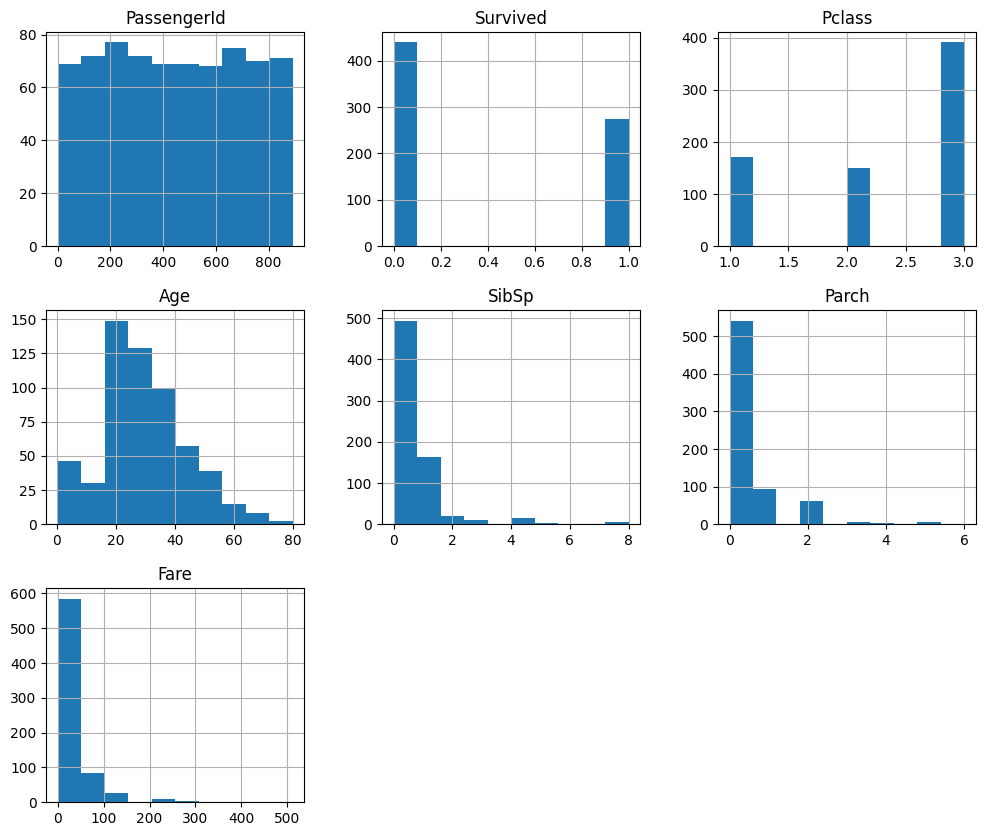

In [12]:
df_train.hist(figsize=(12,10))

### Null Exploration

Initially I wanted to look for a clear pattern in the 3 features with NULLs but knowing that I would be working with XGBoost I decided to leave the NULLs since XGBoost can handle them and I figure there could be information encoded in the NULLs.

#### Age

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

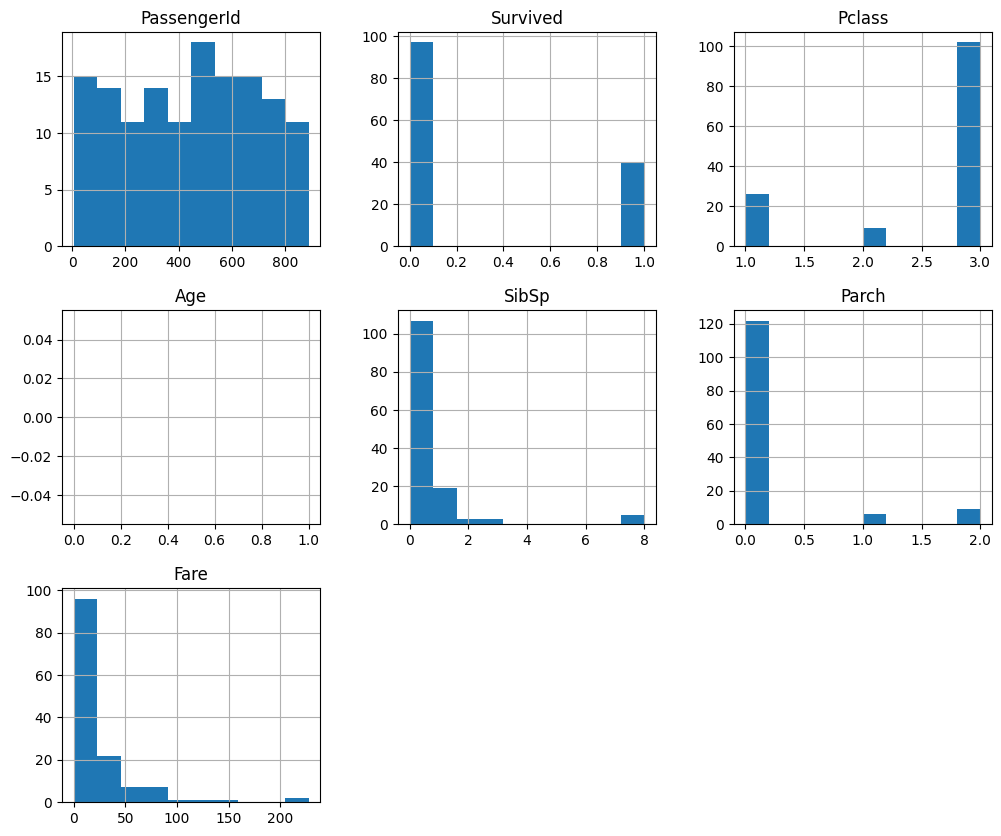

In [13]:
df_train[(df_train['Age'].isnull())].hist(figsize=(12,10))

In [14]:
mean_age = df_train['Age'].mean()
median_age = df_train['Age'].median()

print(f"Mean Age: {mean_age}\nMedian Age: {median_age}")

Mean Age: 29.807686956521735
Median Age: 28.5


In [15]:
#df_train['Age'] = df_train['Age'].fillna(median_age)
#df_train[(df_train['Age'].isnull())].head(10)

#### Cabin

In [16]:
df_train[df_train['Cabin'].isnull()].head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S
652,653,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
557,558,0,1,"Robbins, Mr. Victor",male,NaN,0,0,PC 17757,227.5250,NaN,C
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
402,403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

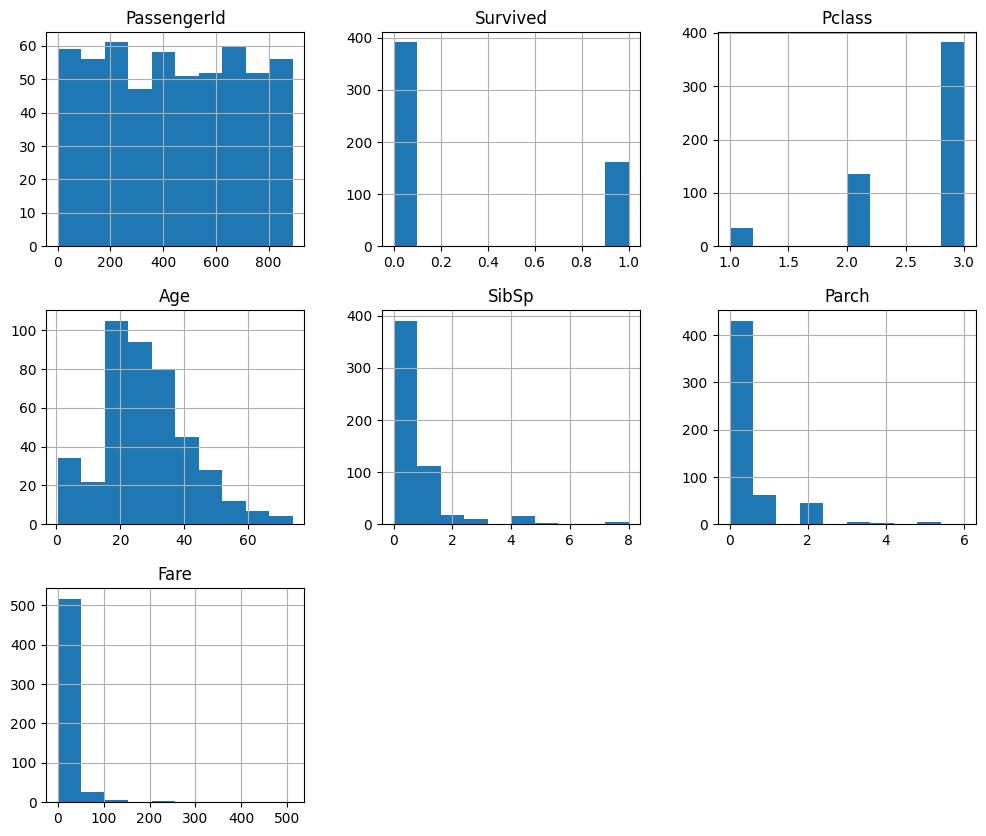

In [17]:
df_train[df_train['Cabin'].isnull()].hist(figsize=(12,10))

#### Embarked

In [18]:
df_train[df_train['Embarked'].isnull()].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN


#### Function

In [19]:
def null_cleaning(df):
    # We are leaving NULLs because XGBoost can handle them so this function serves only as a placeholder
    
    return df

## Feature Engineering

In [20]:
'''
Sex -> IsMale

The reasoning here is straightforward, one-hot encode the categoricals
'''
df_train['IsMale'] = df_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_train.drop(columns=['Sex'], inplace=True)

In [21]:
'''
# Cabin -> CabinType, LogCabinNumber, isCabinType


Cabin is NULL for ~77% of records so I don't want to over emphasize this feature
Cabin clearly has two portions a CabinType and CabinNumber so I split these for a better analysis
CabinNumber had a bit of a right skew so I am sticking with the Log although it doesn't look as normal as I would like
CabinType one-hot resulted in bins that were simply too small so I am going to stick with the simple IsCabinType

'''

df_train['CabinType'] = df_train['Cabin'].str[:1]
df_train['CabinNumber'] = pd.to_numeric(df_train['Cabin'].str[1:], errors='coerce')
df_train['LogCabinNumber'] = df_train['CabinNumber'].apply(lambda x: np.log(x) if x >0 else np.nan)
df_train = df_train.drop(columns=['Cabin'])

df_train['IsCabinType'] = df_train['CabinType'].notna().astype('Int64')
# These were all quite small, with more research I may find a way to group i.e. A,B,C vs D,E,F,G,T
#df_train['IsCabinTypeA'] = df_train['CabinType'].apply(lambda x: 1 if x == 'A' else 0)
#df_train['IsCabinTypeB'] = df_train['CabinType'].apply(lambda x: 1 if x == 'B' else 0)
#df_train['IsCabinTypeC'] = df_train['CabinType'].apply(lambda x: 1 if x == 'C' else 0)
#df_train['IsCabinTypeD'] = df_train['CabinType'].apply(lambda x: 1 if x == 'D' else 0)
#df_train['IsCabinTypeE'] = df_train['CabinType'].apply(lambda x: 1 if x == 'E' else 0)
#df_train['IsCabinTypeF'] = df_train['CabinType'].apply(lambda x: 1 if x == 'F' else 0)
#df_train['IsCabinTypeG'] = df_train['CabinType'].apply(lambda x: 1 if x == 'G' else 0)
#df_train['IsCabinTypeT'] = df_train['CabinType'].apply(lambda x: 1 if x == 'T' else 0)
df_train = df_train.drop(columns=['CabinType', 'CabinNumber'])

In [22]:
'''
# Embarked -> IsEmbarkedCherbourg, IsEmbarkedQueenstown, IsEmbarkedSouthampton

Embarked is a clear one-hot encoding feature as there are only 3 options and there are only 2 NULLs which will be captured with all 0s
Generally to avoid multicolinearity you would want n-1 where n is the number of one-hot encoded features i.e. 2 instead of 3 but tree based models don't care about this
'''

df_train['IsEmbarkedCherbourg'] = df_train['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df_train['IsEmbarkedQueenstown'] = df_train['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df_train['IsEmbarkedSouthampton'] = df_train['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df_train = df_train.drop(columns=['Embarked'])

In [23]:
'''
Pclass -> IsFirstClass, IsSecondClass, IsThirdClass

Pclass a clear one-hot encoded feature with only 3 options and no nulls, again no need to drop 1 for multicolinearity due to tree model
'''

df_train['IsFirstClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 1 else 0)
df_train['IsSecondClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 2 else 0)
df_train['IsThirdClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 3 else 0)
df_train = df_train.drop(columns=['Pclass'])

In [24]:
'''
Name -> Title -> IsWomanMarried, IsUniqueTitle

Name is interesting, I particularly wanted to touch on titles
I figured being married as a woman could be important as well as maybe some very important non-normal titles
'''

df_train['Title'] = df_train['Name'].str.extract(r',\s*(\w+)\.', expand=False)
df_train['IsWomanMarried'] = (df_train['Title'] == 'Mrs').astype('Int64')

standard_titles = ['Mrs', 'Mr', 'Ms', 'Miss']
df_train['IsUniqueTitle'] = (~df_train['Title'].isin(standard_titles)).astype('Int64')
df_train = df_train.drop(columns=['Title','Name'])

In [25]:
'''
Fare -> LogFare

Fare is a classic log candidate as it has a strong right skew like most currency features it created a nice normal distribution
Interestingly some tickets had no fare but I didn't feel this was super important initially and the number was very small
'''


df_train['FarePerPerson'] = (df_train['Fare'] / (1 + df_train['SibSp'] + df_train['Parch']))
#df_train['IsFare'] = (df_train['Fare'] > 0).astype('Int64') # Too few trues
#df_train['LogFare'] = df_train['Fare'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_train['LogFarePerPerson'] = df_train['FarePerPerson'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_train = df_train.drop(columns=['Fare','FarePerPerson'])

In [26]:
'''
SibSp & Parch -> IsAlone, IsNoSibSp, IsGTE2SibSp, IsNoParch, IsGTE2Parch

The count of siblings, partners, parents, children seem quite important to me theoretically
Being alone felt like it would stand out especially when the model can assess this with age in the same tree
Being in a small vs larger group feels interesting to me as well
I think these features will allow for some interesting trees when combined with other features
'''


df_train['IsAlone'] = ((df_train['SibSp'] == 0) & (df_train['Parch'] == 0)).astype('Int64')
df_train['IsNoSibSp'] = (df_train['SibSp'] == 0).astype('Int64')
df_train['IsGTE2SibSp'] = (df_train['SibSp'] >= 2).astype('Int64')
df_train['IsNoParch'] = (df_train['Parch'] == 0).astype('Int64')
df_train['IsGTE2Parch'] = (df_train['Parch'] >=2).astype('Int64')
df_train = df_train.drop(columns=['SibSp','Parch'])

In [27]:
'''
Ticket -> TicketNumber, IsSharedTicket, IsHasTicketPrefix

I feel there is a lot of information in the TicketNumber especially since some have prefixes and there are very clear groupings based on the leading digit, length, and even the numbers themselves
This is a clear candidate to revisit later depending on the models initial performance but I didn't want to go into a rabbit hole just yet
'''

df_train['TicketNumber'] = df_train['Ticket'].apply(lambda x: int(x.split()[-1]) if x.split()[-1].isdigit() else np.nan).astype('Int64')
df_train['IsHasTicketPrefix'] = df_train['Ticket'].apply(lambda x: int(not x.replace('.', '').replace('/', '').split()[0].isdigit()))


ticket_counts = df_train['Ticket'].value_counts()
df_train['TicketGroupSize'] = df_train['Ticket'].map(ticket_counts)
df_train['IsSharedTicket'] = (df_train['TicketGroupSize'] > 1).astype(int)
df_train['IsSharedTicketGTE3'] = (df_train['TicketGroupSize'] >= 3).astype(int)

In [28]:
df_train['TicketNumber'].head(10)

692      1601
481    239854
527     17483
855    392091
801     31921
652      8475
509      1601
557     17757
828    367228
18     345763
Name: TicketNumber, dtype: Int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


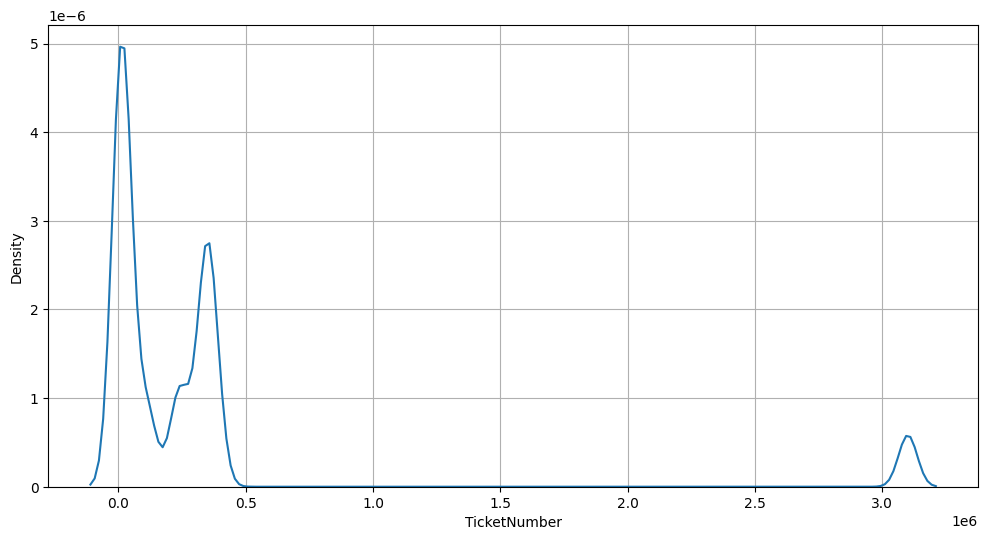

In [29]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_train['TicketNumber'].dropna(), bw_adjust=0.2)
plt.xlabel('TicketNumber')
plt.grid(True)
plt.show()

In [30]:
df_train = df_train.drop(columns=['Ticket','TicketNumber','TicketGroupSize','PassengerId'])

In [31]:
df_train.head(30)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Survived,Age,IsMale,LogCabinNumber,IsCabinType,IsEmbarkedCherbourg,IsEmbarkedQueenstown,IsEmbarkedSouthampton,IsFirstClass,IsSecondClass,...,IsUniqueTitle,LogFarePerPerson,IsAlone,IsNoSibSp,IsGTE2SibSp,IsNoParch,IsGTE2Parch,IsHasTicketPrefix,IsSharedTicket,IsSharedTicketGTE3
692,1,NaN,1,NaN,0,0,0,1,0,0,...,0,4.034166,1,1,0,1,0,0,1,1
481,0,NaN,1,NaN,0,0,0,1,0,1,...,0,NaN,1,1,0,1,0,0,0,0
527,0,NaN,1,4.553877,1,0,0,1,1,0,...,0,5.401682,1,1,0,1,0,1,0,0
855,1,18.0,0,NaN,0,0,0,1,0,0,...,0,1.542229,0,1,0,0,0,0,0,0
801,1,31.0,0,NaN,0,0,0,1,0,1,...,0,2.169054,0,0,0,0,0,1,1,0
652,0,21.0,1,NaN,0,0,0,1,0,0,...,0,2.132188,1,1,0,1,0,0,0,0
509,1,26.0,1,NaN,0,0,0,1,0,0,...,0,4.034166,1,1,0,1,0,0,1,1
557,0,NaN,1,NaN,0,1,0,0,1,0,...,0,5.427260,1,1,0,1,0,1,1,1
828,1,NaN,1,NaN,0,0,1,0,0,0,...,0,2.047693,1,1,0,1,0,0,0,0
18,0,31.0,0,NaN,0,0,0,1,0,0,...,0,2.197225,0,0,0,1,0,0,0,0


In [32]:
df_train.dtypes

Survived                   int64
Age                      float64
IsMale                     int64
LogCabinNumber           float64
IsCabinType                Int64
IsEmbarkedCherbourg        int64
IsEmbarkedQueenstown       int64
IsEmbarkedSouthampton      int64
IsFirstClass               int64
IsSecondClass              int64
IsThirdClass               int64
IsWomanMarried             Int64
IsUniqueTitle              Int64
LogFarePerPerson         float64
IsAlone                    Int64
IsNoSibSp                  Int64
IsGTE2SibSp                Int64
IsNoParch                  Int64
IsGTE2Parch                Int64
IsHasTicketPrefix          int64
IsSharedTicket             int64
IsSharedTicketGTE3         int64
dtype: object

In [33]:
'''
data types are all over the place, let's go ahead and loop through the columns and make them uniform
'''

for col in df_train.columns:
    if str(df_train[col].dtype) == 'Int64':
        df_train[col] = df_train[col].astype('int32')
    if np.issubdtype(df_train[col].dtype, np.integer):
        df_train[col] = df_train[col].astype('int32')
    if np.issubdtype(df_train[col].dtype, np.floating):
        df_train[col] = df_train[col].astype('float32')

In [34]:
df_train.dtypes

Survived                   int32
Age                      float32
IsMale                     int32
LogCabinNumber           float32
IsCabinType                int32
IsEmbarkedCherbourg        int32
IsEmbarkedQueenstown       int32
IsEmbarkedSouthampton      int32
IsFirstClass               int32
IsSecondClass              int32
IsThirdClass               int32
IsWomanMarried             int32
IsUniqueTitle              int32
LogFarePerPerson         float32
IsAlone                    int32
IsNoSibSp                  int32
IsGTE2SibSp                int32
IsNoParch                  int32
IsGTE2Parch                int32
IsHasTicketPrefix          int32
IsSharedTicket             int32
IsSharedTicketGTE3         int32
dtype: object

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'IsMale'}>,
        <Axes: title={'center': 'LogCabinNumber'}>],
       [<Axes: title={'center': 'IsCabinType'}>,
        <Axes: title={'center': 'IsEmbarkedCherbourg'}>],
       [<Axes: title={'center': 'IsEmbarkedQueenstown'}>,
        <Axes: title={'center': 'IsEmbarkedSouthampton'}>],
       [<Axes: title={'center': 'IsFirstClass'}>,
        <Axes: title={'center': 'IsSecondClass'}>],
       [<Axes: title={'center': 'IsThirdClass'}>,
        <Axes: title={'center': 'IsWomanMarried'}>],
       [<Axes: title={'center': 'IsUniqueTitle'}>,
        <Axes: title={'center': 'LogFarePerPerson'}>],
       [<Axes: title={'center': 'IsAlone'}>,
        <Axes: title={'center': 'IsNoSibSp'}>],
       [<Axes: title={'center': 'IsGTE2SibSp'}>,
        <Axes: title={'center': 'IsNoParch'}>],
       [<Axes: title={'center': 'IsGTE2Parch'}>,
        <Axes: title={'center': 'IsHasTi

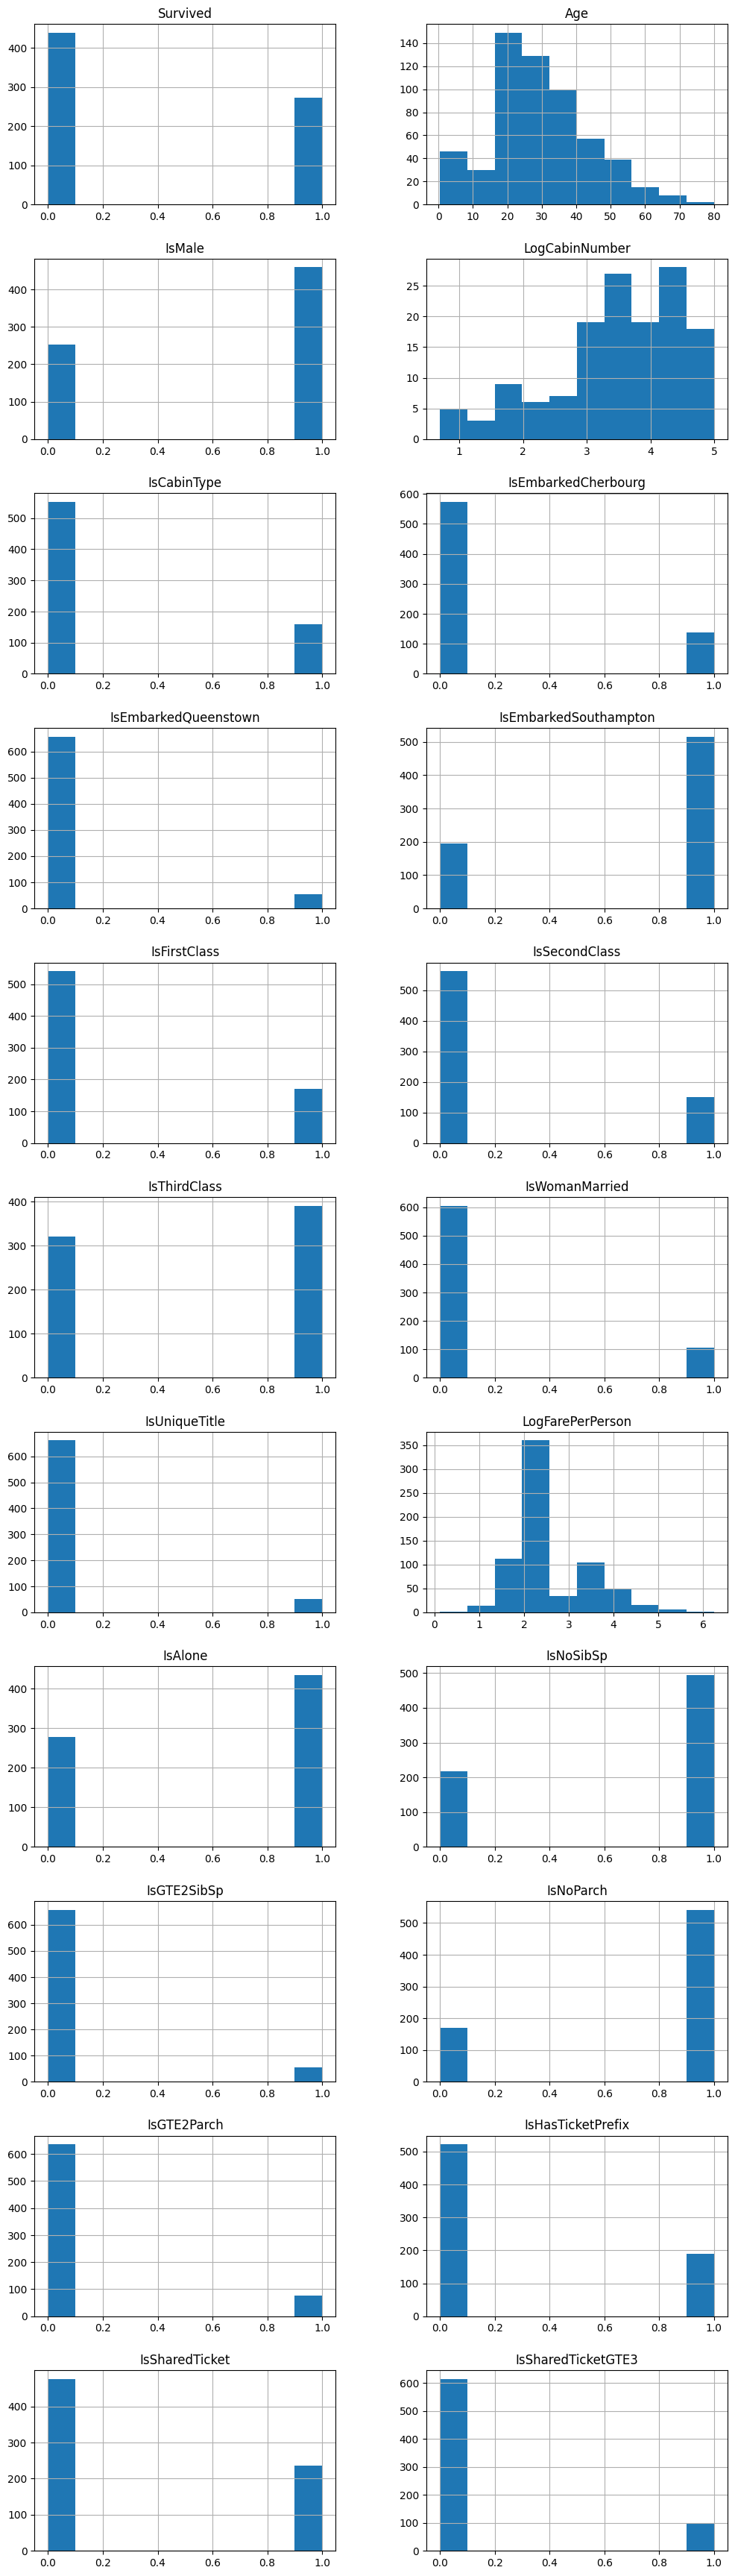

In [35]:
custom_hist(df_train)

In [36]:
def feature_engineering(df):

    df_train = df
    
    df_train['IsMale'] = df_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    df_train.drop(columns=['Sex'], inplace=True)
    
    df_train['CabinType'] = df_train['Cabin'].str[:1]
    df_train['CabinNumber'] = pd.to_numeric(df_train['Cabin'].str[1:], errors='coerce')
    df_train['LogCabinNumber'] = df_train['CabinNumber'].apply(lambda x: np.log(x) if x >0 else np.nan)
    df_train = df_train.drop(columns=['Cabin'])
    df_train['IsCabinType'] = df_train['CabinType'].notna().astype('Int64')
    df_train = df_train.drop(columns=['CabinType', 'CabinNumber'])
    
    df_train['IsEmbarkedCherbourg'] = df_train['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
    df_train['IsEmbarkedQueenstown'] = df_train['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
    df_train['IsEmbarkedSouthampton'] = df_train['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
    df_train = df_train.drop(columns=['Embarked'])
    
    df_train['IsFirstClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 1 else 0)
    df_train['IsSecondClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 2 else 0)
    df_train['IsThirdClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 3 else 0)
    df_train = df_train.drop(columns=['Pclass'])
    
    df_train['Title'] = df_train['Name'].str.extract(r',\s*(\w+)\.', expand=False)
    df_train['IsWomanMarried'] = (df_train['Title'] == 'Mrs').astype('Int64')
    standard_titles = ['Mrs', 'Mr', 'Ms', 'Miss']
    df_train['IsUniqueTitle'] = (~df_train['Title'].isin(standard_titles)).astype('Int64')
    df_train = df_train.drop(columns=['Title','Name'])
    
    df_train['FarePerPerson'] = (df_train['Fare'] / (1 + df_train['SibSp'] + df_train['Parch']))
    df_train['LogFarePerPerson'] = df_train['FarePerPerson'].apply(lambda x: np.log(x) if x > 0 else np.nan)
    df_train = df_train.drop(columns=['Fare','FarePerPerson'])
    
    df_train['IsAlone'] = ((df_train['SibSp'] == 0) & (df_train['Parch'] == 0)).astype('Int64')
    df_train['IsNoSibSp'] = (df_train['SibSp'] == 0).astype('Int64')
    df_train['IsGTE2SibSp'] = (df_train['SibSp'] >= 2).astype('Int64')
    df_train['IsNoParch'] = (df_train['Parch'] == 0).astype('Int64')
    df_train['IsGTE2Parch'] = (df_train['Parch'] >=2).astype('Int64')
    df_train = df_train.drop(columns=['SibSp','Parch'])
    
    df_train['TicketNumber'] = df_train['Ticket'].apply(lambda x: int(x.split()[-1]) if x.split()[-1].isdigit() else np.nan).astype('Int64')
    df_train['IsHasTicketPrefix'] = df_train['Ticket'].apply(lambda x: int(not x.replace('.', '').replace('/', '').split()[0].isdigit()))
    ticket_counts = df_train['Ticket'].value_counts()
    df_train['TicketGroupSize'] = df_train['Ticket'].map(ticket_counts)
    df_train['IsSharedTicket'] = (df_train['TicketGroupSize'] > 1).astype(int)
    df_train['IsSharedTicketGTE3'] = (df_train['TicketGroupSize'] >= 3).astype(int)
    df_train = df_train.drop(columns=['Ticket','TicketNumber','TicketGroupSize','PassengerId'])

    for col in df_train.columns:
        if str(df_train[col].dtype) == 'Int64':
            df_train[col] = df_train[col].astype('int32')
        if np.issubdtype(df_train[col].dtype, np.integer):
            df_train[col] = df_train[col].astype('int32')
        if np.issubdtype(df_train[col].dtype, np.floating):
            df_train[col] = df_train[col].astype('float32')
    
    return df_train

In [37]:
cat_cols = [
    'IsMale',
    'IsCabinType',
    #'IsEmbarkedCherbourg',
    'IsEmbarkedQueenstown',
    'IsEmbarkedSouthampton',
    #'IsFirstClass',
    'IsSecondClass',
    'IsThirdClass',
    'IsWomanMarried',
    'IsUniqueTitle',
    'IsAlone',
    #'IsNoSibSp',
    'IsGTE2SibSp',
    'IsNoParch',
    #'IsGTE2Parch',
    #'IsHasTicketPrefix',
    'IsSharedTicket',
    'IsSharedTicketGTE3'
    
]

num_cols = [
    'Age',
    #'LogCabinNumber',
    'LogFarePerPerson'
]


In [38]:
'''
Scaling

You will read that in XGBoost scaling doesn't have much of an effect but I have personally seen performance boosts
Also, scaled features are much easier to analyze for feature importance
'''

scaler = MinMaxScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
#joblib.dump(scaler, f"scaler.pkl") # Placeholder code for later extracting out the scaler pickle

In [39]:
# Numerical Feature Relevance

y = df_train['Survived']
rows = []

for col in num_cols:
    s = df_train[col]
    r, p = pearsonr(s.dropna(),y[s.notna()])
    rows.append({'feature': col, 'point_biserial_r': r, 'p_value': p})

pd.DataFrame(rows).sort_values('p_value')

,feature,point_biserial_r,p_value
1,LogFarePerPerson,0.295158,1.692000e-15
0,Age,-0.084268,4.339665e-02


In [40]:
# Categorical Feature Relevance

y = df_train['Survived']
rows = []

for col in cat_cols:
    ct = pd.crosstab(df_train[col], df_train['Survived'])
    chi2, p, _, _ = chi2_contingency(ct)
    rows.append({'feature': col, 'chi2_stat': chi2, 'p_value': p})

pd.DataFrame(rows).sort_values('p_value')

,feature,chi2_stat,p_value
0,IsMale,212.377920,4.159916e-48
1,IsCabinType,85.767908,2.023435e-20
6,IsWomanMarried,83.927825,5.131715e-20
5,IsThirdClass,71.063600,3.458931e-17
8,IsAlone,32.184285,1.402203e-08
11,IsSharedTicket,25.782915,3.820556e-07
3,IsEmbarkedSouthampton,23.931038,9.984893e-07
10,IsNoParch,16.279925,5.463976e-05
7,IsUniqueTitle,3.157750,7.556727e-02
4,IsSecondClass,2.884787,8.941984e-02


The following will be candidates for drops or further feature engineering due to large p-values:
- LogCabinNumber 
- IsHasTicketPrefix 
- IsEmbarkedQueenstown 
- isGTE2Parch 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


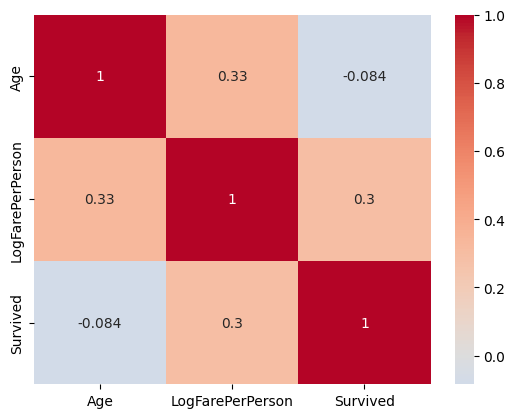

In [41]:
# Numerical Feature Correlation
num_df = df_train[num_cols + ['Survived']]
corr_matrix = num_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


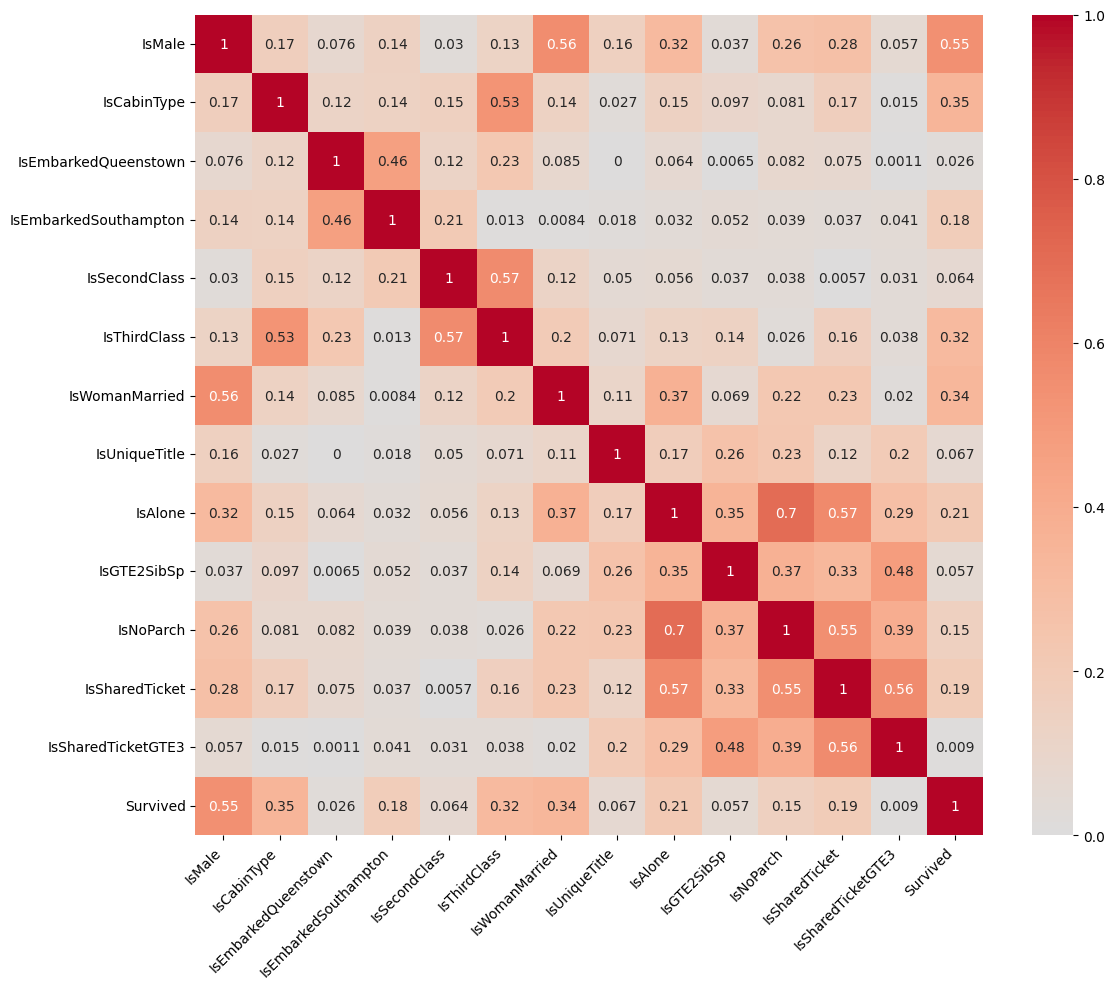

In [42]:
# Categorical Feature Correlation
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2 = chi2_contingency(ct)[0]
    n = ct.sum().sum()
    phi2 = chi2 / n
    r, k = ct.shape
    return np.sqrt(phi2 / min(k-1, r-1))

all_cat_cols = cat_cols + ['Survived']
cramers_matrix = pd.DataFrame(index=all_cat_cols, columns=all_cat_cols)
for col1 in all_cat_cols:
    for col2 in all_cat_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            v = cramers_v(df_train[col1], df_train[col2])
            cramers_matrix.loc[col1, col2] = v

cramers_matrix = cramers_matrix.astype(float)
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', center=0)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

IsAlone has a high correlation (0.84) with IsNoSibSp as well as with IsNoParch (0.69).
Generally I look at correlation > 0.8 initially but since it has high correlation with 2 other features it is a great candidate for potentially dropping.

Other notables are IsEmbarkedSouthampton with IsEmbarkedCherbourg and IsFirstClass and IsCabinType.

In [43]:
def preprocessing(df, num_cols):
    df = null_cleaning(df)
    df = feature_engineering(df)
    df[num_cols] = scaler.transform(df[num_cols]) # will need to ensure we use the scaler.pkl later

    return df

In [44]:
df_val = preprocessing(df_val, num_cols)

In [45]:
X_train = df_train.drop(columns=['Survived'])
y_train = df_train['Survived']

X_val = df_val.drop(columns=['Survived'])
y_val = df_val['Survived']

In [46]:
initial_model = train_xgb_model(X_train, y_train, X_val, y_val)

[0]	validation_0-logloss:0.65430
[1]	validation_0-logloss:0.62181
[2]	validation_0-logloss:0.59621
[3]	validation_0-logloss:0.57595
[4]	validation_0-logloss:0.55868
[5]	validation_0-logloss:0.54482
[6]	validation_0-logloss:0.53923
[7]	validation_0-logloss:0.53266
[8]	validation_0-logloss:0.53028
[9]	validation_0-logloss:0.52057
[10]	validation_0-logloss:0.51394
[11]	validation_0-logloss:0.50322
[12]	validation_0-logloss:0.49615
[13]	validation_0-logloss:0.49403
[14]	validation_0-logloss:0.48796
[15]	validation_0-logloss:0.48589
[16]	validation_0-logloss:0.48261
[17]	validation_0-logloss:0.47869
[18]	validation_0-logloss:0.47896
[19]	validation_0-logloss:0.47808
[20]	validation_0-logloss:0.47703
[21]	validation_0-logloss:0.47695
[22]	validation_0-logloss:0.47682
[23]	validation_0-logloss:0.47743
[24]	validation_0-logloss:0.47764
[25]	validation_0-logloss:0.47857
[26]	validation_0-logloss:0.48053
[27]	validation_0-logloss:0.47976
[28]	validation_0-logloss:0.48196
[29]	validation_0-loglos

Performance is still bad, let's take a look at the model SHAP, feature importance, and calibration curves to decide where we want feature engineering to improve.

Experimenting with filling heavily null fields like Age with a summary statistic such as Median will likely be helpful here and worth testing.

Parch and SibSp are much less important than I would have thought, we likely need to engineer a better feature maybe PartySize where it is 1 + SibSp + Parch